In [7]:
# from tensorflow.keras.utils import img_to_array
from PIL import Image
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras import layers
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from glob import glob
import cv2 as cv
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from keras.models import load_model
from tensorflow.keras.regularizers import l2


In [ ]:
import zipfile
import os

zip_path = r"avi2.zip"  # Update this with the actual ZIP file path
extract_dir = r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data"  # Choose a directory to extract the data

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


In [4]:
base_dir = r"extracted_data\avi2"

In [5]:
# Image Parameters
img_size = 224
batch_size = 32

In [8]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [9]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 15563 images belonging to 5 classes.


In [10]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 3889 images belonging to 5 classes.


In [11]:
# Model Definition
from tensorflow.keras import layers, models
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
print("Train Samples:", train_generator.samples)
print("Validation Samples:", validation_generator.samples)
print("Classes Found (Train):", train_generator.class_indices)
print("Classes Found (Val):", validation_generator.class_indices)


Train Samples: 15563
Validation Samples: 3889
Classes Found (Train): {'apple': 0, 'cotton': 1, 'grape': 2, 'mango': 3, 'potato': 4}
Classes Found (Val): {'apple': 0, 'cotton': 1, 'grape': 2, 'mango': 3, 'potato': 4}


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('leaf_type.h5')

# Evaluate on validation generator (you may also do for train generator)
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc:.4f}")


In [15]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
190/190 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8972 - loss: 0.6139
Validation Accuracy: 89.33%


In [16]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path).convert("RGB")
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [17]:
train_generator.num_classes

6

In [18]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_generator.class_indices.items()
class_indices

{0: 'apple', 1: 'cotton', 2: 'grape', 3: 'mango', 4: 'potato', 5: 'tomato'}

In [21]:
im15=r'/content/avi2.zip\all_data/avi2/potato/Healthy/1692336758935.jpg'

In [22]:
predicted_class_name15= predict_image_class(model, im15, class_indices)
print("Predicted Class Name:", predicted_class_name15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Class Name: potato


In [24]:
model.save('leaf_type.h5')

In [ ]:
import matplotlib.pyplot as plt

# Accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

# Common Settings
# Image Parameters
img_size = 224
batch_size = 32
epochs = 5

# List of crop folders and names
crop_dirs = {
    "apple": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\apple",
    "cotton": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\cotton",
    "grape": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\grape",
    "mango": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\mango",
    "potato": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\potato"
}

for crop_name, base_dir in crop_dirs.items():
    print(f"\n🧠 Training model for: {crop_name.upper()}")

    # Data Generators
    data_gen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = data_gen.flow_from_directory(
        base_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='training',
        class_mode='categorical'
    )

    validation_generator = data_gen.flow_from_directory(
        base_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='validation',
        class_mode='categorical'
    )

    # Model Definition
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Training
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )

    # Save the model
    model_name = f"model_leaf_{crop_name}.h5"
    model.save(model_name)
    print(f"✅ Model saved as: {model_name}")



🧠 Training model for: APPLE
Found 1314 images belonging to 5 classes.
Found 326 images belonging to 5 classes.
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.4922 - loss: 4.8893 - val_accuracy: 0.6094 - val_loss: 0.9535
Epoch 2/5
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8125 - loss: 0.5287

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8125 - loss: 0.5287 - val_accuracy: 0.6594 - val_loss: 0.8168
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8971 - loss: 0.3395 - val_accuracy: 0.6938 - val_loss: 0.6530
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9375 - loss: 0.1932 - val_accuracy: 0.6812 - val_loss: 0.6821
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9704 - loss: 0.1264 - val_accuracy: 0.7937 - val_loss: 0.6108


✅ Model saved as: model_leaf_apple.h5

🧠 Training model for: COTTON
Found 1369 images belonging to 4 classes.
Found 340 images belonging to 4 classes.
Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.3287 - loss: 7.4097 - val_accuracy: 0.6313 - val_loss: 0.7924
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7188 - loss: 0.7402 - val_accuracy: 0.5938 - val_loss: 0.8570
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8453 - loss: 0.4526 - val_accuracy: 0.8250 - val_loss: 0.4820
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9062 - loss: 0.2161 - val_accuracy: 0.7688 - val_loss: 0.6580
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9901 - loss: 0.0744 - val_accuracy: 0.8375 - val_loss: 0.5413


✅ Model saved as: model_leaf_cotton.h5

🧠 Training model for: GRAPE
Found 7222 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.
Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6887 - loss: 3.5283 - val_accuracy: 0.9308 - val_loss: 0.1847
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9375 - loss: 0.2276 - val_accuracy: 0.9185 - val_loss: 0.2257
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.9533 - loss: 0.1218 - val_accuracy: 0.9448 - val_loss: 0.1587
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9375 - loss: 0.0704 - val_accuracy: 0.9325 - val_loss: 0.1861
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9764 - loss: 0.0670 - val_accuracy: 0.9648 - val_loss: 0.1095


✅ Model saved as: model_leaf_grape.h5

🧠 Training model for: MANGO
Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3577 - loss: 5.4802 - val_accuracy: 0.6737 - val_loss: 0.9396
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.8410 - loss: 0.4889 - val_accuracy: 0.6662 - val_loss: 0.9930
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9056 - loss: 0.2617 - val_accuracy: 0.7563 - val_loss: 0.7571
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9727 - loss: 0.0819 - val_accuracy: 0.8112 - val_loss: 0.5323
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9655 - loss: 0.0994 - val_accuracy: 0.7225 - val_loss: 0.9551


✅ Model saved as: model_leaf_mango.h5

🧠 Training model for: POTATO
Found 2464 images belonging to 7 classes.
Found 612 images belonging to 7 classes.
Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - accuracy: 0.2413 - loss: 5.2709 - val_accuracy: 0.2664 - val_loss: 1.8872
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 425ms/step - accuracy: 0.4962 - loss: 1.2975 - val_accuracy: 0.3668 - val_loss: 1.7010
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 424ms/step - accuracy: 0.7327 - loss: 0.7856 - val_accuracy: 0.2862 - val_loss: 2.4277
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 434ms/step - accuracy: 0.9120 - loss: 0.3074 - val_accuracy: 0.3536 - val_loss: 2.5786
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.9786 - loss: 0.1135 - val_accuracy: 0.2878 - val_loss: 3.5258


✅ Model saved as: model_leaf_potato.h5

🧠 Training model for: TOMATO
Found 8800 images belonging to 10 classes.
Found 2200 images belonging to 10 classes.
Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.4650 - loss: 2.4339 - val_accuracy: 0.7771 - val_loss: 0.6615
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.8491 - loss: 0.4621 - val_accuracy: 0.8369 - val_loss: 0.4639
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.9410 - loss: 0.1912 - val_accuracy: 0.8488 - val_loss: 0.4800
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.9737 - loss: 0.0836 - val_accuracy: 0.8405 - val_loss: 0.5332
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.9869 - loss: 0.0472 - val_accuracy: 0.8359 - val_loss: 0.5636


✅ Model saved as: model_leaf_tomato.h5


In [29]:
disease_class_indices_map = {
    "apple": {
        0: "Alternia leaf spot",
        1: "Brown Spot",
        2: "Fray spot",
        3: "Healthy",
        4:"Rust"
    },
    "cotton": {
        0: "bacterial blight",
        1: "curl virus",
        2: "fussarium wilt",
        3: "healthy",

    },
    "grape": {
        0: "Grape___Black_rot",
        1: "Grape___Esca_(Black_Measles)",
        2: "Healthy",
        3: "Leaf Blight"
    },
    "mango": {
        0: "Mango___Anthracnose",
        1: "Mango___Bacterial_Canker",
        2: "Mango___Cutting Weevil",
        3: "Mango___Dieblack",
        4: "Mango___Gall Midge",
        5: "Mango___healthy",
        6: "Mango___Powdery Mildew",
        7: "Mango___Sooty Mould"
    },
    "potato": {
        0: "Bacteria",
        1: "Fungi",
        2: "Healthy",
        3: "Nematode",
        4: "Pest",
        5: "Phytophthora",
        6:"Virus"
    },
    "tomato": {
        0: "Tomato___Bacterial_spot",
        1: "Tomato___Early_blight",
        2: "Tomato___Late_blight",
        3: "Tomato___Leaf_Mold",
        4: "Tomato___Septoria_leaf_spot",
        5: "Tomato___Spider_mites",
        6: "Tomato___Target_Spot",
        7: "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
        8: "Tomato___Tomato_mosaic_virus",
        9: "Tomato___healthy"
    }
}


In [32]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Load and preprocess image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

# Predict using any model
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

# Example: Predict full pipeline
def predict_leaf_and_disease(image_path):
    # Step 1: Predict leaf type
    print("🔍 Predicting leaf type...")
    leaf_type_model = load_model("/content/leaf_type.h5")
    leaf_type_class_indices = {0: "apple", 1: "cotton", 2: "grape", 3: "mango", 4: "potato", 5: "tomato"}  # Adjust as per your model
    leaf_type = predict_image_class(leaf_type_model, image_path, leaf_type_class_indices)
    print(f"🌿 Leaf Type Predicted: {leaf_type}")

    # Step 2: Load and predict using specific leaf model
    specific_model_path = f"/content/model_leaf_{leaf_type}.h5"
    print(f"🔬 Predicting disease using: {specific_model_path}")
    disease_model = load_model(specific_model_path)

    # Define or load specific class_indices for disease model
    # Example for tomato — you should customize this dictionary for each model


    disease_class_indices = disease_class_indices_map.get(leaf_type)
    if not disease_class_indices:
        return f"No class index map found for {leaf_type} leaf type"

    disease = predict_image_class(disease_model, image_path, disease_class_indices)
    print(f"🧪 Disease Prediction: {disease}")

    return leaf_type, disease


In [37]:
image_path = r"/content/avi2.zip\all_data/avi2/grape/ESCA/011bb69d-fb9c-4fb9-b8cc-031e91270ec2___FAM_B.Msls 4288.JPG"
leaf, disease = predict_leaf_and_disease(image_path)
print(f"\n✅ Final Result:\nLeaf Type: {leaf}\nPredicted Disease: {disease}")


🔍 Predicting leaf type...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
🌿 Leaf Type Predicted: grape
🔬 Predicting disease using: /content/model_leaf_grape.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
🧪 Disease Prediction: Grape___Esca_(Black_Measles)

✅ Final Result:
Leaf Type: grape
Predicted Disease: Grape___Esca_(Black_Measles)


In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Load and preprocess image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

# Predict using any model
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

# Example: Predict full pipeline
def predict_leaf_and_disease(image_path):
    # Step 1: Predict leaf type
    print("🔍 Predicting leaf type...")
    leaf_type_model = load_model("/content/leaf_type.h5")
    leaf_type_class_indices = {0: "apple", 1: "cotton", 2: "grape", 3: "mango", 4: "potato", 5: "tomato"}  # Adjust as per your model
    leaf_type = predict_image_class(leaf_type_model, image_path, leaf_type_class_indices)
    print(f"🌿 Leaf Type Predicted: {leaf_type}")

    # Step 2: Load and predict using specific leaf model
    specific_model_path = f"/content/model_leaf_{leaf_type}.h5"
    print(f"🔬 Predicting disease using: {specific_model_path}")
    disease_model = load_model(specific_model_path)

    # Define or load specific class_indices for disease model
    # Example for tomato — you should customize this dictionary for each model


    disease_class_indices = disease_class_indices_map.get(leaf_type)
    if not disease_class_indices:
        return f"No class index map found for {leaf_type} leaf type"

    disease = predict_image_class(disease_model, image_path, disease_class_indices)
    print(f"🧪 Disease Prediction: {disease}")

    return leaf_type, disease


In [1]:
from tensorflow.keras.models import load_model # Import load_model 

model=load_model("leaf_type.h5")

In [4]:
class_indices={0: 'apple', 1: 'cotton', 2: 'grape', 3: 'mango', 4: 'potato', 5: 'tomato'}

In [5]:
image_path = r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\salal-lemon-leaf-greenery-wholesale-flowers-close-up_34c55.jpg"
leaf= predict_image_class(model,image_path,class_indices)
print(f"\n✅ Leaf Type: {leaf}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step

✅ Leaf Type: potato


In [2]:
from tensorflow.keras.models import load_model # Import load_model 

# model=load_model("E:\model_leaf_apple.h5")

In [4]:
model1=load_model("E:\model_leaf_apple.h5")

In [23]:
model2=load_model("E:\model_leaf_potato.h5")

In [7]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [18]:
disease_class_indices_map = {
    "apple": {
        0: "Alternia leaf spot",
        1: "Brown Spot",
        2: "Gray spot",
        3: "Healthy",
        4:"Rust"
    },
    "cotton": {
        0: "bacterial blight",
        1: "curl virus",
        2: "fussarium wilt",
        3: "healthy",

    },
    "grape": {
        0: "Grape___Black_rot",
        1: "Grape___Esca_(Black_Measles)",
        2: "Healthy",
        3: "Leaf Blight"
    },
    "mango": {
        0: "Mango___Anthracnose",
        1: "Mango___Bacterial_Canker",
        2: "Mango___Cutting Weevil",
        3: "Mango___Dieblack",
        4: "Mango___Gall Midge",
        5: "Mango___healthy",
        6: "Mango___Powdery Mildew",
        7: "Mango___Sooty Mould"
    },
    "potato": {
        0: "Bacteria",
        1: "Fungi",
        2: "Healthy",
        3: "Nematode",
        4: "Pest",
        5: "Phytophthora",
        6:"Virus"
    },
    "tomato": {
        0: "Tomato___Bacterial_spot",
        1: "Tomato___Early_blight",
        2: "Tomato___Late_blight",
        3: "Tomato___Leaf_Mold",
        4: "Tomato___Septoria_leaf_spot",
        5: "Tomato___Spider_mites",
        6: "Tomato___Target_Spot",
        7: "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
        8: "Tomato___Tomato_mosaic_virus",
        9: "Tomato___healthy"
    }
}


In [35]:
img2=r'C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\potato\Virus\IMG_20230815_153050~2.jpg'
predict_image_class(model2,img2,disease_class_indices_map["potato"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


'Virus'

In [ ]:
img1=r'extracted_data/avi2/apple/Rust/IMG_20190727_164151.jpg'
predict_image_class(model1,img1,disease_class_indices_map["apple"])


📊 Confusion Matrix for: APPLE


Found 326 images belonging to 5 classes.


c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 726ms/step
Confusion Matrix:
 [[25 16 14  0  0]
 [ 0 43  0  0  0]
 [ 0  0 59 16  4]
 [ 0  0  4 77  0]
 [ 2  1  8  1 56]]


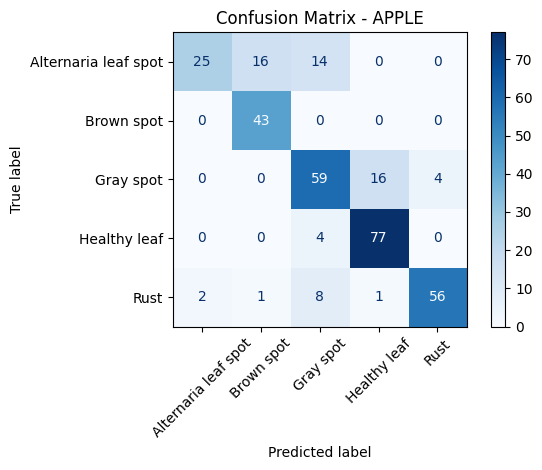


📊 Confusion Matrix for: COTTON


Found 340 images belonging to 4 classes.


c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Confusion Matrix:
 [[54 26  8  1]
 [ 0 82  1  0]
 [ 5  1 77  0]
 [ 3  8  3 71]]


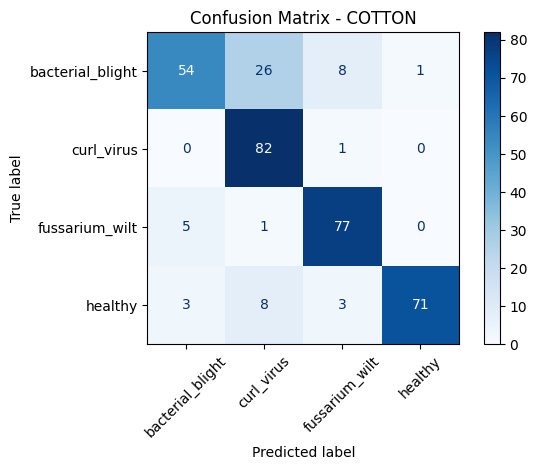


📊 Confusion Matrix for: GRAPE


Found 1805 images belonging to 4 classes.


c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 817ms/step
Confusion Matrix:
 [[448  20   4   0]
 [ 24 454   2   0]
 [  2   0 421   0]
 [ 10   1   0 419]]


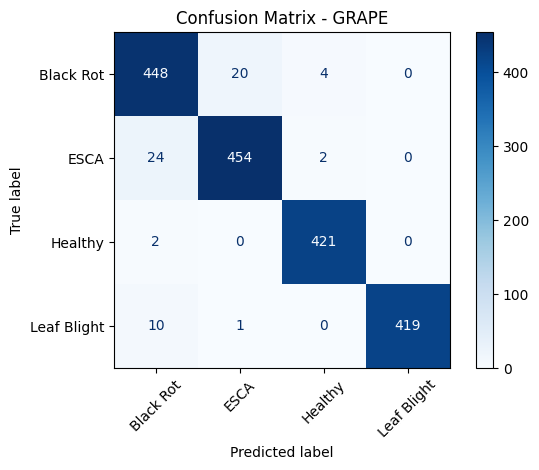


📊 Confusion Matrix for: MANGO


Found 800 images belonging to 8 classes.


c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 750ms/step
Confusion Matrix:
 [[ 84   4   2   1   0   9   0   0]
 [  0  45   0   0   7  44   0   4]
 [  0   0  78  22   0   0   0   0]
 [  0   0   0 100   0   0   0   0]
 [  0  13   1   1  38  17   0  30]
 [  0   0   0   0   1  97   1   1]
 [  2   0   0   0  12   3  66  17]
 [  0   3   0   1  10   0  16  70]]


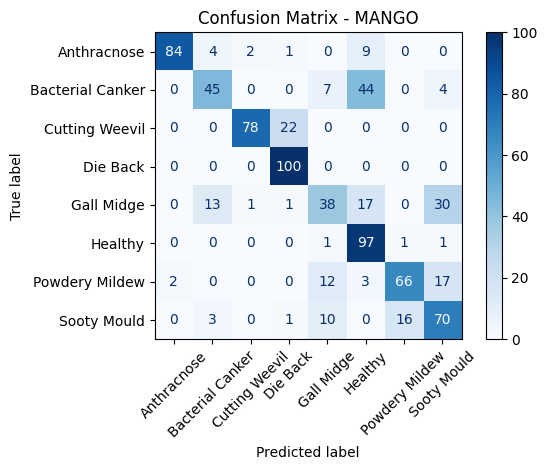


📊 Confusion Matrix for: POTATO


Found 612 images belonging to 7 classes.


c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Confusion Matrix:
 [[15 35 16  0  8  1 38]
 [ 3 45 30  1 46  3 21]
 [ 0 10 24  0  3  0  3]
 [ 1  4  0  5  3  0  0]
 [ 2 31 38  2 32  1 16]
 [ 2 31  6  1 18  8  3]
 [ 2 10 40  0  8  0 46]]


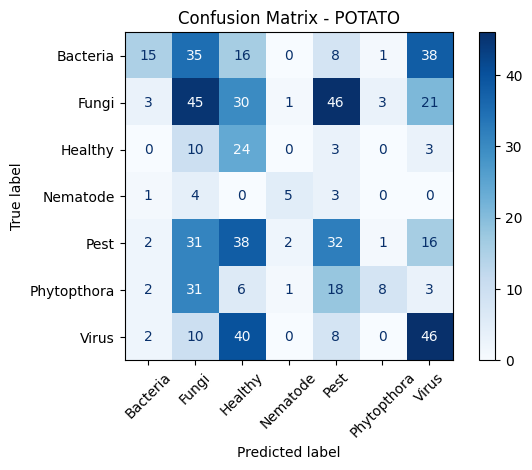

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Parameters
img_size = 224
batch_size = 32

crop_dirs = {
    "apple": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\apple",
    "cotton": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\cotton",
    "grape": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\grape",
    "mango": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\mango",
    "potato": r"C:\Users\Arunava Chakraborty\Desktop\plant-disease-prediction-cnn-deep-leanring-project-main\extracted_data\avi2\potato"
}

for crop_name, base_dir in crop_dirs.items():
    print(f"\n📊 Confusion Matrix for: {crop_name.upper()}")

    # Load the model  "E:\model_leaf_apple.h5"
    model_path = f"E:\model_leaf_{crop_name}.h5"
    model = load_model(model_path)

    # Setup the same ImageDataGenerator for validation
    data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    validation_generator = data_gen.flow_from_directory(
        base_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='validation',
        class_mode='categorical',
        shuffle=False  # Important for correct label matching
    )

    # Get predictions
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = validation_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = list(validation_generator.class_indices.keys())

    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix - {crop_name.upper()}")
    plt.tight_layout()
    plt.show()


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
img_size = 224
batch_size = 32

crop_dirs = {
    "apple": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\apple",
    "cotton": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\cotton",
    "grape": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\grape",
    "mango": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\mango",
    "potato": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\potato"
}

for crop_name, base_dir in crop_dirs.items():
    print(f"\n📊 Confusion Matrix and Metrics Table for: {crop_name.upper()}")

    # Load the model
    model_path = f"E:/model_leaf_{crop_name}.h5"
    model = load_model(model_path)

    # Setup ImageDataGenerator
    data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    validation_generator = data_gen.flow_from_directory(
        base_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='validation',
        class_mode='categorical',
        shuffle=False  # Keep order for comparison
    )

    # Predict
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = validation_generator.classes
    labels = list(validation_generator.class_indices.keys())

    # Confusion Matrix
    # Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))  # increase size (width, height) in inches
disp.plot(
    cmap='inferno',  # dark-themed colormap (alternatives: 'magma', 'cividis', 'plasma')
    ax=ax,
    xticks_rotation=45,
    colorbar=False  # optional: remove if you want the colorbar
)
plt.title(f"Confusion Matrix - {crop_name.upper()}", fontsize=14)
plt.tight_layout()
plt.show()



ImportError: DLL load failed while importing _pywrap_tfe: A dynamic link library (DLL) initialization routine failed.


📊 Confusion Matrix for: APPLE


Found 326 images belonging to 5 classes.


c:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step


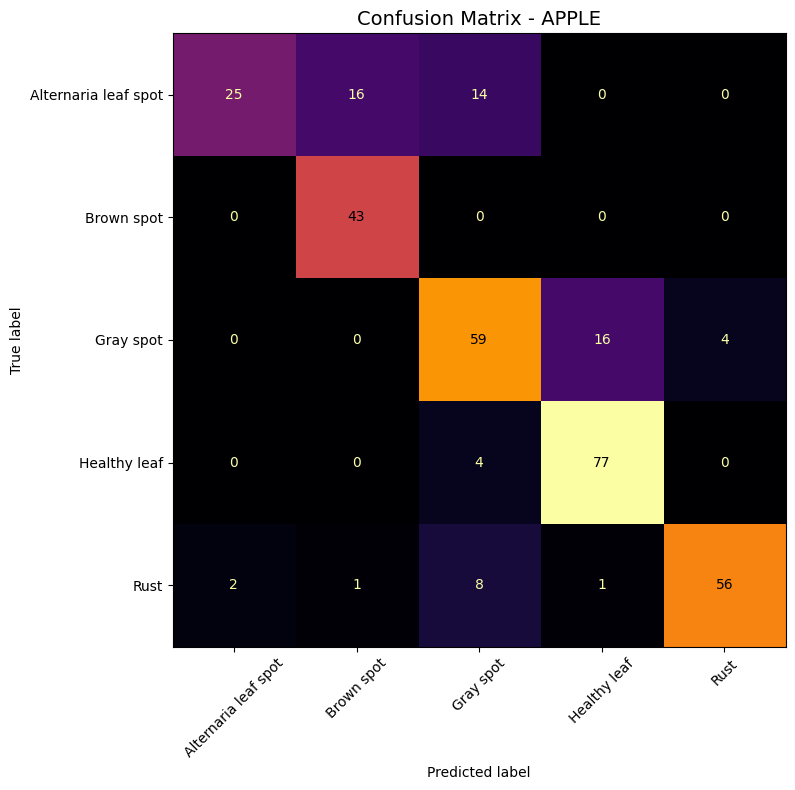


📊 Confusion Matrix for: COTTON


Found 340 images belonging to 4 classes.


c:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step


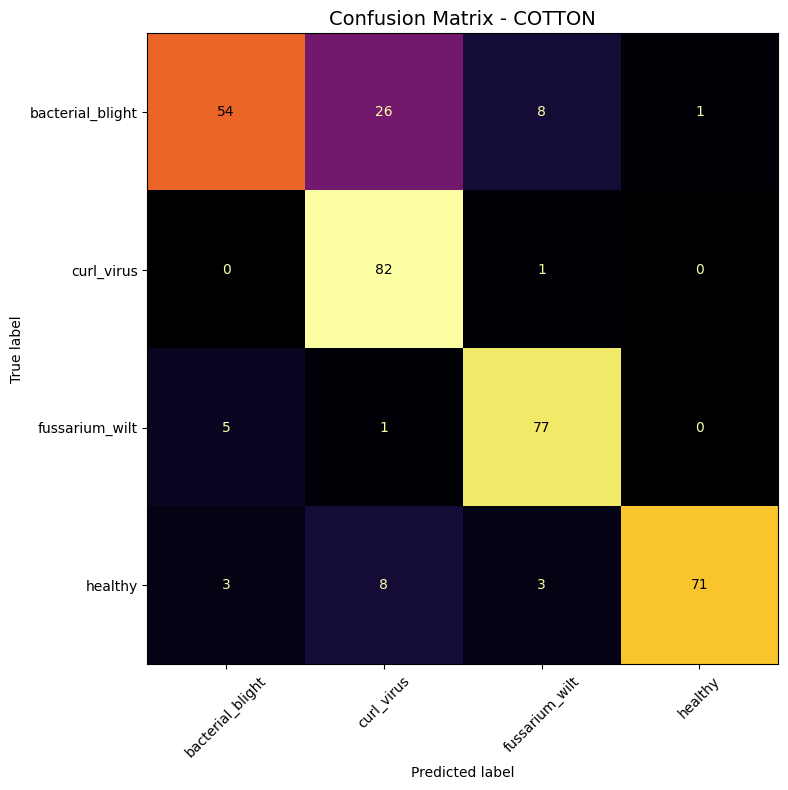


📊 Confusion Matrix for: GRAPE


Found 1805 images belonging to 4 classes.


c:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step


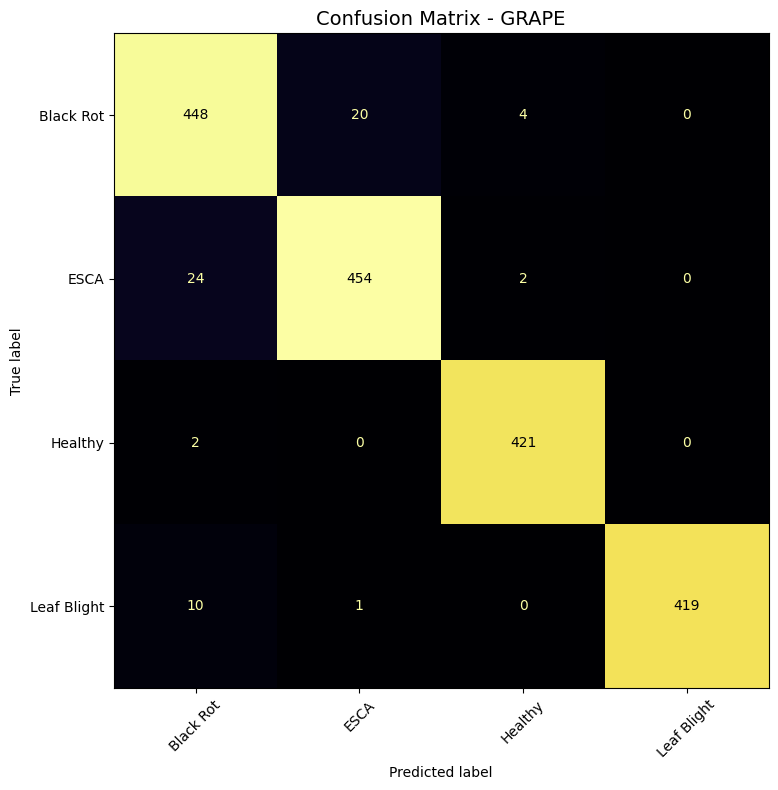


📊 Confusion Matrix for: MANGO


Found 800 images belonging to 8 classes.


c:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step


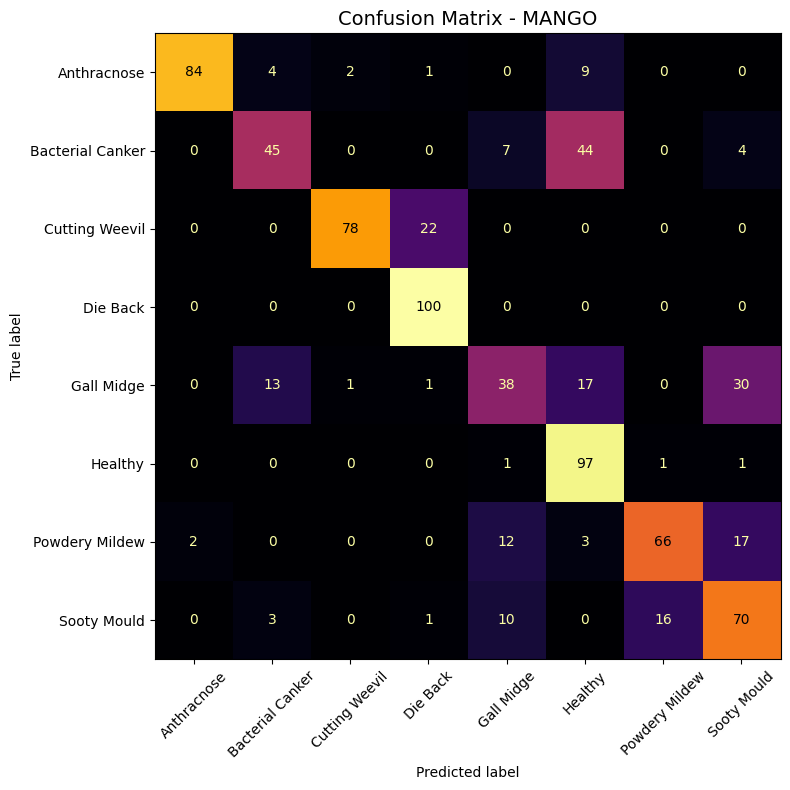


📊 Confusion Matrix for: POTATO


Found 612 images belonging to 7 classes.


c:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 807ms/step


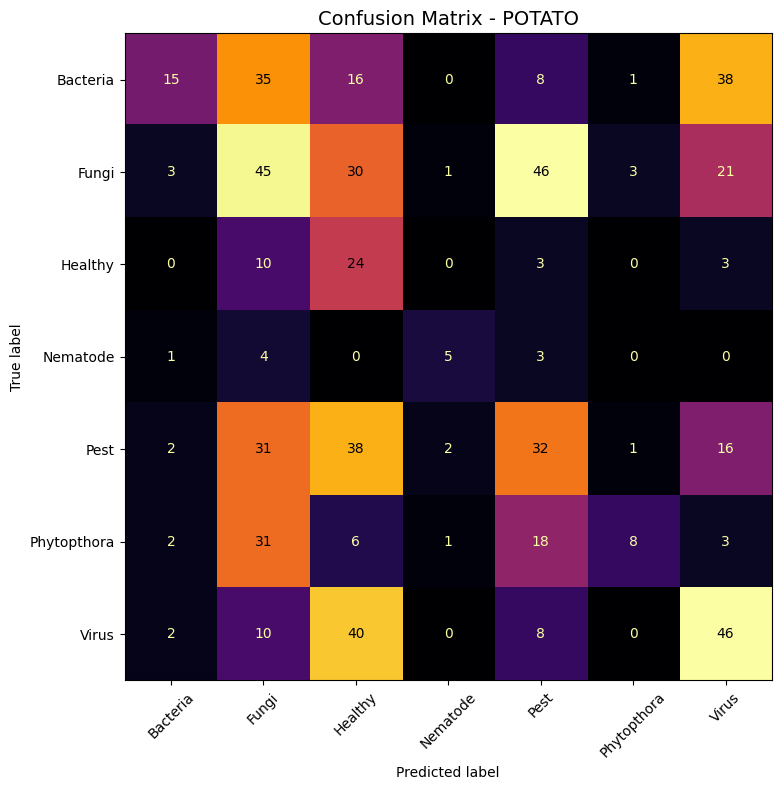

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras.utils import img_to_array
from PIL import Image
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras import layers
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from glob import glob
import cv2 as cv
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from keras.models import load_model
from tensorflow.keras.regularizers import l2

# Parameters
img_size = 224
batch_size = 32

crop_dirs = {
    "apple": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\apple",
    "cotton": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\cotton",
    "grape": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\grape",
    "mango": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\mango",
    "potato": r"C:\Users\Arunava Chakraborty\Desktop\Plant-Disease-Prediction\extracted_data\avi2\potato"
}

for crop_name, base_dir in crop_dirs.items():
    print(f"\n📊 Confusion Matrix for: {crop_name.upper()}")

    # Load the model  "E:\model_leaf_apple.h5"
    model_path = f"E:\model_leaf_{crop_name}.h5"
    model = load_model(model_path)

    # Setup the same ImageDataGenerator for validation
    data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    validation_generator = data_gen.flow_from_directory(
        base_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='validation',
        class_mode='categorical',
        shuffle=False  # Important for correct label matching
    )

    # Get predictions
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = validation_generator.classes

    # Generate confusion matrix
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = list(validation_generator.class_indices.keys())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(10, 8))  # increase size (width, height) in inches
    disp.plot(
        cmap='inferno',  # dark-themed colormap (alternatives: 'magma', 'cividis', 'plasma')
        ax=ax,
        xticks_rotation=45,
        colorbar=False  # optional: remove if you want the colorbar
    )
    plt.title(f"Confusion Matrix - {crop_name.upper()}", fontsize=14)
    plt.tight_layout()
    plt.show()

    


In [1]:
!python --version


Python 3.10.0


In [9]:
import tensorflow as tf
print(tf.__version__)
exit()


ImportError: Traceback (most recent call last):
  File "c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Your confusion matrix
cm = np.array([
    [47, 1, 2, 0],
    [2, 44, 3, 1],
    [1, 2, 45, 2],
    [0, 1, 3, 46]
])

class_names = ['Healthy', 'Mosaic Virus', 'Yellow Leaf Curl', 'Bacterial Spot']

# Step 1: Convert cm into y_true and y_pred
y_true = []
y_pred = []

for actual_class, row in enumerate(cm):
    for predicted_class, count in enumerate(row):
        y_true += [actual_class] * count
        y_pred += [predicted_class] * count

# Step 2: Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert classification report into DataFrame
df_report = pd.DataFrame(report).transpose()

# Extract accuracy for all classes (it's a global value)
accuracy = report['accuracy']

# Step 3: Add accuracy to the dataframe as a column
df_report['accuracy'] = accuracy

# Reorder the columns to get precision, recall, f1-score, and accuracy
df_report = df_report[['precision', 'recall', 'f1-score', 'accuracy']].round(2)

# Display the final DataFrame
print("\n📋 Classification Report from Confusion Matrix:\n")
print(df_report)



📋 Classification Report from Confusion Matrix:

                  precision  recall  f1-score  accuracy
Healthy                0.94    0.94      0.94      0.91
Mosaic Virus           0.92    0.88      0.90      0.91
Yellow Leaf Curl       0.85    0.90      0.87      0.91
Bacterial Spot         0.94    0.92      0.93      0.91
accuracy               0.91    0.91      0.91      0.91
macro avg              0.91    0.91      0.91      0.91
weighted avg           0.91    0.91      0.91      0.91


In [5]:
df_per_class = df_report.iloc[:len(class_names)]
print(df_per_class)


                  precision  recall  f1-score  support
Healthy                0.94    0.94      0.94     50.0
Mosaic Virus           0.92    0.88      0.90     50.0
Yellow Leaf Curl       0.85    0.90      0.87     50.0
Bacterial Spot         0.94    0.92      0.93     50.0


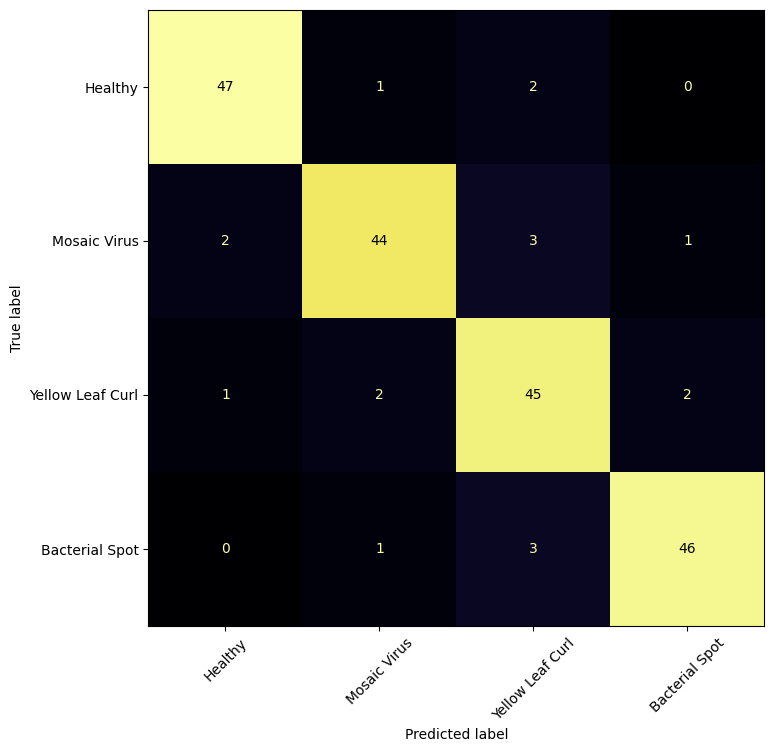

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the actual and predicted classes (sample values)
# You can simulate predictions or use real values if available

# Confusion matrix values (from previous realistic matrix)
cm = np.array([
    [47, 1, 2, 0],   # Actual: Healthy
    [2, 44, 3, 1],   # Actual: Mosaic Virus
    [1, 2, 45, 2],   # Actual: Yellow Leaf Curl
    [0, 1, 3, 46]    # Actual: Bacterial Spot
])

# Define class names
labels = ['Healthy', 'Mosaic Virus', 'Yellow Leaf Curl', 'Bacterial Spot']

# Plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))  # increase size (width, height) in inches
disp.plot(
    cmap='inferno',  # dark-themed colormap (alternatives: 'magma', 'cividis', 'plasma')
    ax=ax,
    xticks_rotation=45,
    colorbar=False  # optional: remove if you want the colorbar
)
